# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(123)

num_devices = 40  
num_days = 10     
full_history_days = 180 

columns = ['Date', 'Device_ID', 'Temperature', 'Humidity', 'Voltage', 'Failure', 'Days_to_Failure']
data = []

# Generate Failing Devices and Failing Days

In [3]:
def generate_device_profile():
    profile = {
        'Temperature': np.random.choice([
            np.random.uniform(18, 22),    
            np.random.uniform(22, 27),    
            np.random.uniform(27, 35)    
        ], p=[0.5, 0.3, 0.2]),
        
        'Humidity': np.random.choice([
            np.random.uniform(45, 55),     
            np.random.uniform(35, 45),    
            np.random.uniform(55, 65)     
        ], p=[0.5, 0.25, 0.25]),
        
        'Voltage': np.random.choice([
            np.random.uniform(220, 230), 
            np.random.uniform(210, 220),  
            np.random.uniform(230, 245)   
        ], p=[0.6, 0.2, 0.2])
    }
    
    risk_score = 0
    
    if profile['Temperature'] < 22:
        risk_score += 0.1
    elif profile['Temperature'] < 27:
        risk_score += 0.3
    else:
        temp_factor = (profile['Temperature'] - 27) / 8
        risk_score += 0.5 + temp_factor**2
    
    voltage_deviation = abs(profile['Voltage'] - 225) / 15
    risk_score += voltage_deviation * 0.3
    
    humidity_deviation = abs(profile['Humidity'] - 50) / 15
    risk_score += humidity_deviation * 0.2
    
    risk_score = max(0.1, min(1.0, risk_score))
    profile['risk_score'] = risk_score
    
    return profile

In [4]:
device_profiles = {}
for device_id in range(1, num_devices + 1):
    device_profiles[device_id] = generate_device_profile()

failing_devices = []
failure_days = {}

for device_id, profile in device_profiles.items():
    adjusted_risk = max(0.3, profile['risk_score'])
    failing_devices.append(device_id)

    max_fail_day = int(full_history_days * (1 - adjusted_risk * 0.8))
    max_fail_day = max(max_fail_day, 51)
    
    min_fail_day = max(max_fail_day - 60, 50)
    if min_fail_day >= max_fail_day:
        min_fail_day = max_fail_day - 1
    
    failure_days[device_id] = np.random.randint(min_fail_day, max_fail_day)

# Generate time series

In [5]:
def generate_time_series(base_value, num_days, std_dev, has_weekly_pattern=True, 
                         deterioration_start=None, failure_day=None, risk_score=0.5):
    """
    Generate realistic time series with:
    - Daily cycles (e.g., higher temps during day)
    - Weekly cycles (e.g., lower usage on weekends)
    - Gradual deterioration for failing devices
    - Clear precursor signals before failure
    """
    series = np.ones(num_days) * base_value
    
    days = np.arange(num_days)
    daily_cycle = np.sin(days * (2 * np.pi / 1)) * std_dev * 0.5
    series += daily_cycle
    
    if has_weekly_pattern:
        weekly_cycle = np.sin(days * (2 * np.pi / 7)) * std_dev * 0.3
        series += weekly_cycle
    
    if deterioration_start is not None and failure_day is not None:
        deterioration_factor_multiplier = 0.15 + (risk_score * 0.2)
        
        for i in range(num_days):
            if i >= deterioration_start:
                progress = (i - deterioration_start) / max(1, (failure_day - deterioration_start))
                if i < failure_day:
                    deterioration_factor = np.exp(progress * (1 + risk_score)) - 1
                    series[i] += deterioration_factor * base_value * deterioration_factor_multiplier
                    
                    if progress > 0.6:
                        spike_prob = progress * (0.3 + risk_score * 0.3)
                        if np.random.random() < spike_prob:
                            series[i] += np.random.uniform(0, base_value * (0.2 + risk_score * 0.1))
    for i in range(num_days):
        noise_std = std_dev
        if deterioration_start is not None and failure_day is not None and i >= deterioration_start:
            progress = min(1.0, (i - deterioration_start) / max(1, (failure_day - deterioration_start)))
            noise_std *= (1 + progress * (1 + risk_score))
        
        series[i] += np.random.normal(0, noise_std)
    
    return series

In [6]:
start_date = datetime.now() - timedelta(days=full_history_days)

# Generate Data of days

In [7]:
for device_id in range(1, num_devices + 1):
    profile = device_profiles[device_id]
    is_failing = device_id in failing_devices 
    
    deterioration_start = None
    failure_day = None
    
    if is_failing:
        failure_day = failure_days[device_id]
        deterioration_window = int(30 + (1 - profile['risk_score']) * 50)
        deterioration_start = max(0, failure_day - deterioration_window)
    
    temp_series = generate_time_series(
        profile['Temperature'], full_history_days, 1.0, False,
        deterioration_start, failure_day, profile['risk_score']
    )
    
    humidity_series = generate_time_series(
        profile['Humidity'], full_history_days, 2.0, True,
        deterioration_start, failure_day, profile['risk_score']
    )
    
    voltage_series = generate_time_series(
        profile['Voltage'], full_history_days, 1.5, False,
        deterioration_start, failure_day, profile['risk_score']
    )
    
    for day in range(full_history_days):
        current_date = start_date + timedelta(days=day)
        
        temp = temp_series[day]
        humidity = humidity_series[day]
        voltage = voltage_series[day]
        
        if temp > profile['Temperature'] + 4:
            humidity -= (temp - profile['Temperature']) * 0.3
        
        if abs(humidity - 50) > 12:
            voltage_fluctuation = (abs(humidity - 50) - 12) * 0.15
            voltage += np.random.normal(0, voltage_fluctuation)
        
        failure = 0
        days_to_failure = -1
        
        if is_failing:
            if day == failure_day:
                failure = 1
                days_to_failure = 0
            elif day < failure_day:
                days_to_failure = failure_day - day
        
        data.append([
            current_date.strftime('%Y-%m-%d'), 
            f'Device_{device_id}', 
            round(max(0, temp), 2), 
            round(max(0, humidity), 2), 
            round(max(0, voltage), 2),
            failure,
            days_to_failure
        ])


# Prepare Random Forest

In [8]:
df = pd.DataFrame(data, columns=columns)

latest_date = pd.to_datetime(df['Date']).max()
ten_days_ago = latest_date - timedelta(days=9)
df_sample = df[pd.to_datetime(df['Date']) >= ten_days_ago]

df.to_csv('full_server_degradation_dataset.csv', index=False)
df_sample.to_csv('server_degradation_sample_400.csv', index=False)

print(f"Full dataset created with {len(df)} records")
print(f"Sample dataset created with {len(df_sample)} records")

df['Warning'] = df['Days_to_Failure'].apply(lambda x: 1 if 0 < x <= 30 else 0)

df_model = df.copy()
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model = df_model.sort_values(by=['Device_ID', 'Date'])

df_model['Day_of_Week'] = df_model['Date'].dt.dayofweek
df_model['Month'] = df_model['Date'].dt.month

df_model['Temp_Humidity_Ratio'] = df_model['Temperature'] / df_model['Humidity']
df_model['Temp_Voltage_Ratio'] = df_model['Temperature'] / df_model['Voltage']
df_model['Humidity_Voltage_Ratio'] = df_model['Humidity'] / df_model['Voltage']

grouped = df_model.groupby('Device_ID')
df_model['Temperature_7d_mean'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_model['Temperature_7d_std'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df_model['Humidity_7d_mean'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_model['Humidity_7d_std'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df_model['Voltage_7d_mean'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_model['Voltage_7d_std'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

df_model['Temperature_trend'] = grouped['Temperature'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
df_model['Humidity_trend'] = grouped['Humidity'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
df_model['Voltage_trend'] = grouped['Voltage'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())

df_model = df_model.fillna(0)

feature_columns = [
    'Temperature', 'Humidity', 'Voltage',
    'Day_of_Week', 'Month',
    'Temp_Humidity_Ratio', 'Temp_Voltage_Ratio', 'Humidity_Voltage_Ratio',
    'Temperature_7d_mean', 'Temperature_7d_std', 
    'Humidity_7d_mean', 'Humidity_7d_std',
    'Voltage_7d_mean', 'Voltage_7d_std',
    'Temperature_trend', 'Humidity_trend', 'Voltage_trend'
]

scaler = StandardScaler()
X = df_model[feature_columns]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)

y_warning = df_model['Warning']
y_days = df_model['Days_to_Failure']

X_train, X_test, y_warning_train, y_warning_test = train_test_split(X_scaled, y_warning, test_size=0.3, random_state=42)
X_train_days, X_test_days, y_days_train, y_days_test = train_test_split(X_scaled, y_days, test_size=0.3, random_state=42)

param_grid_classifier = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_clf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_classifier,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search_clf.fit(X_train, y_warning_train)
best_clf = grid_search_clf.best_estimator_
y_warning_pred = best_clf.predict(X_test)


Full dataset created with 7200 records
Sample dataset created with 400 records


# Train Random Forest


Random Forest Evaluation:
Warning Classifier Accuracy: 0.9843
Warning Classifier F1 Score: 0.9529
Days to Failure MAE: 4.0510
Days to Failure R²: 0.9612

Top 10 Features for Warning Prediction:
Voltage: 0.3660
Voltage_7d_mean: 0.2227
Voltage_7d_std: 0.1374
Voltage_trend: 0.0691
Humidity: 0.0564
Humidity_7d_mean: 0.0393
Temperature: 0.0208
Humidity_7d_std: 0.0191
Temperature_7d_mean: 0.0146
Temperature_7d_std: 0.0141

Visualizations saved for Device_1
Failure occurs at day 82


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


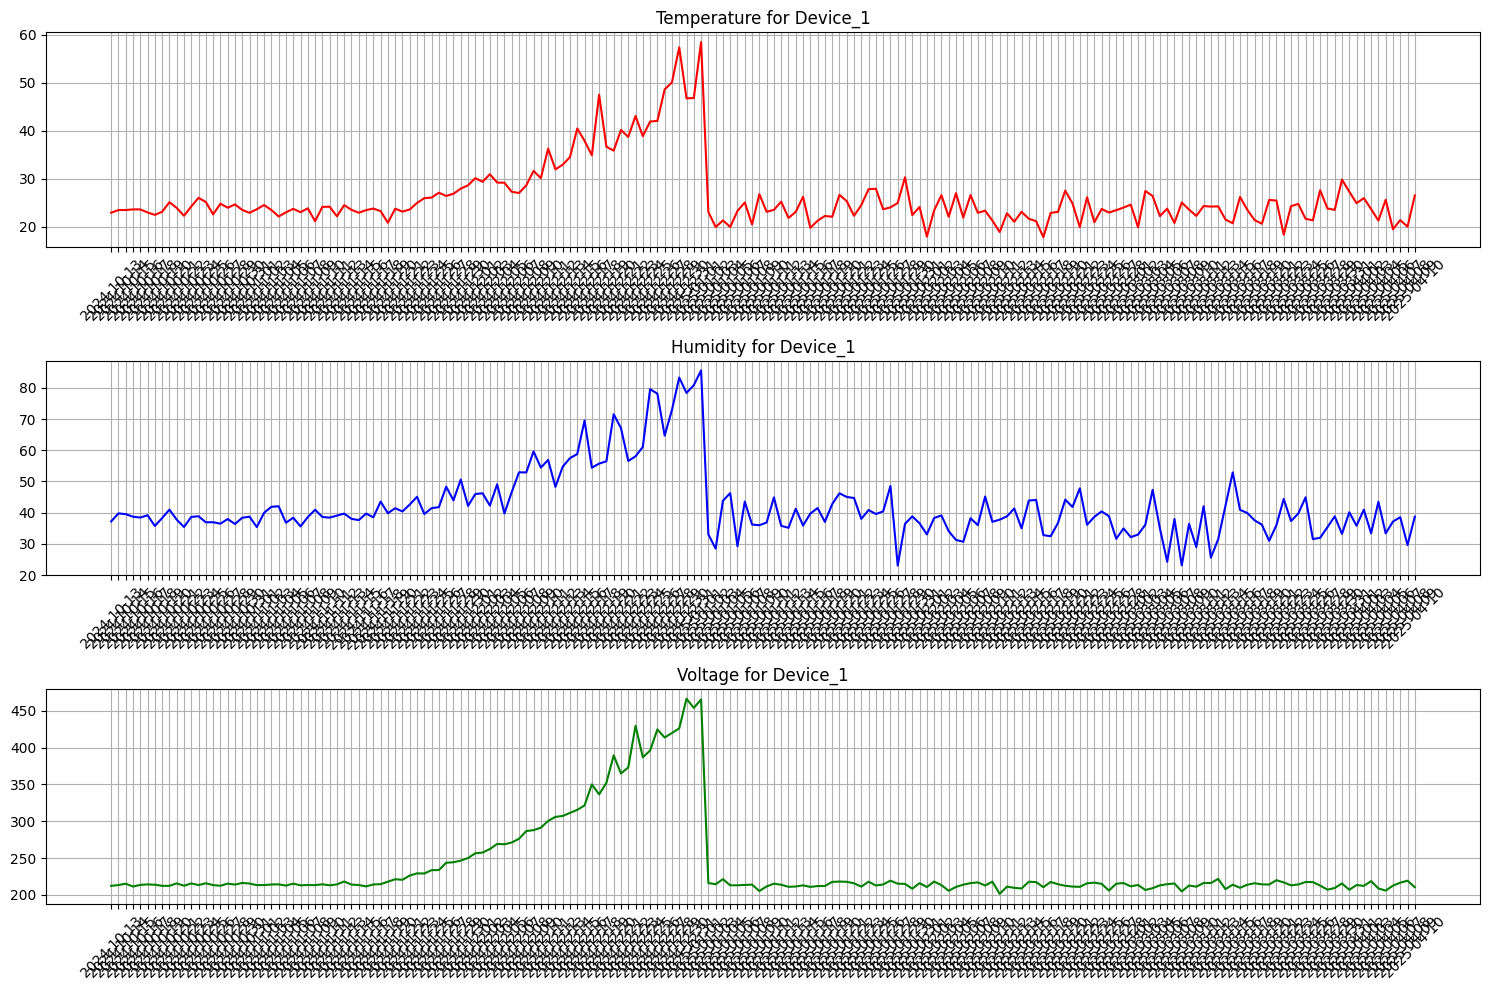

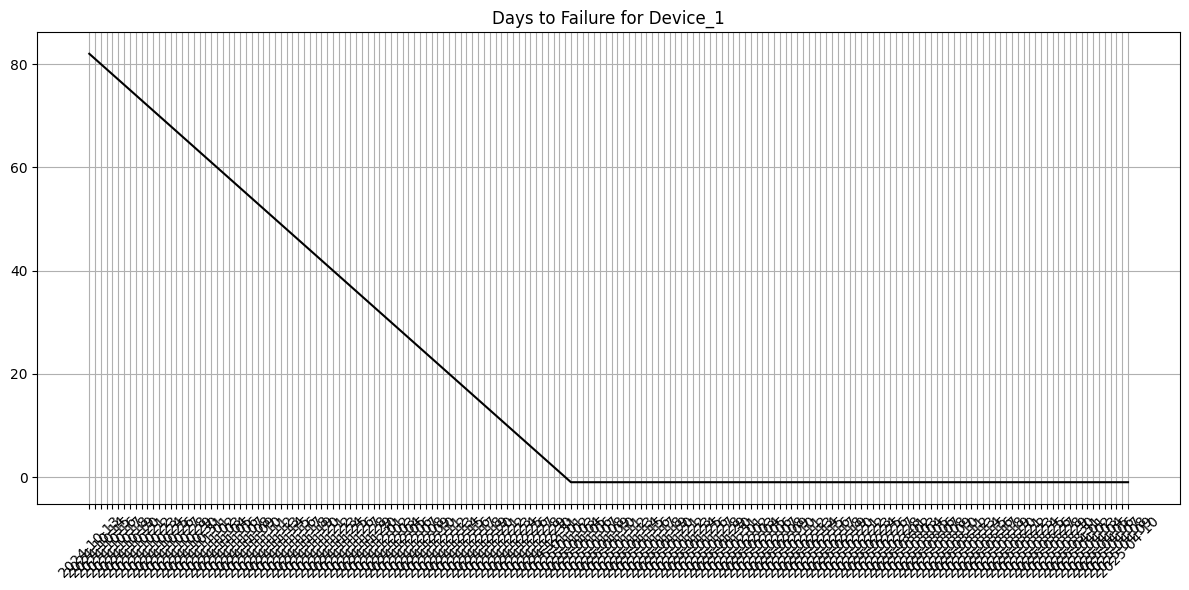

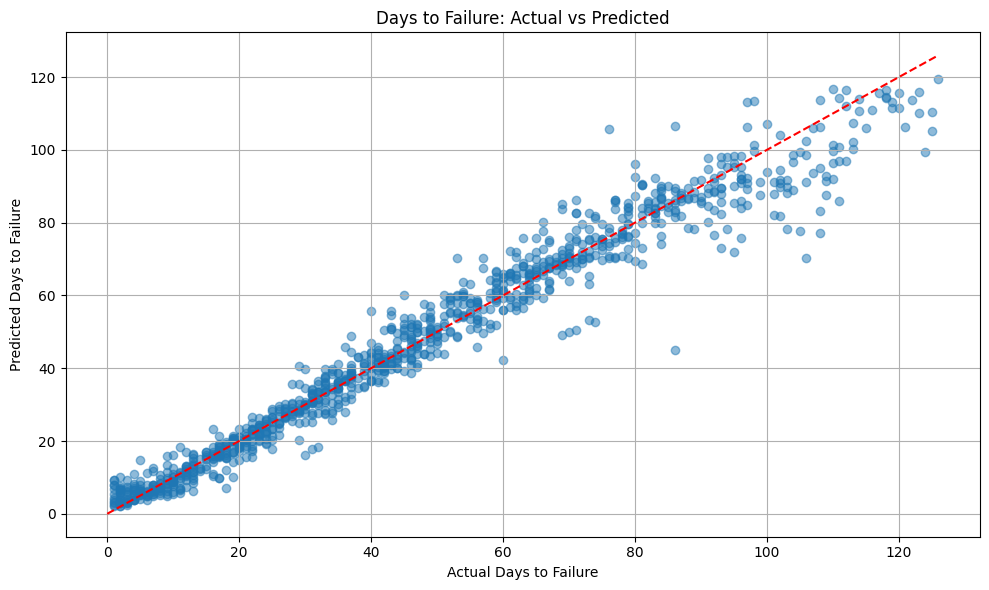

In [9]:
days_mask_train = y_days_train.values > 0 
days_mask_test = y_days_test.values > 0   

X_train_days_filtered = X_train_days.loc[days_mask_train]
y_days_train_filtered = y_days_train.loc[days_mask_train]
X_test_days_filtered = X_test_days.loc[days_mask_test]
y_days_test_filtered = y_days_test.loc[days_mask_test]

if len(X_train_days_filtered) > 0 and len(X_test_days_filtered) > 0:
    param_grid_regressor = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    grid_search_reg = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid_regressor,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid_search_reg.fit(X_train_days_filtered, y_days_train_filtered)
    best_reg = grid_search_reg.best_estimator_
    y_days_pred = best_reg.predict(X_test_days_filtered)

    print("\nRandom Forest Evaluation:")
    print(f"Warning Classifier Accuracy: {accuracy_score(y_warning_test, y_warning_pred):.4f}")
    print(f"Warning Classifier F1 Score: {f1_score(y_warning_test, y_warning_pred):.4f}")
    
    print(f"Days to Failure MAE: {mean_absolute_error(y_days_test_filtered, y_days_pred):.4f}")
    print(f"Days to Failure R²: {r2_score(y_days_test_filtered, y_days_pred):.4f}")

    print("\nTop 10 Features for Warning Prediction:")
    importances = best_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for i in range(min(10, len(feature_columns))):
        print(f"{feature_columns[indices[i]]}: {importances[indices[i]]:.4f}")
    
    if failing_devices:
        device_id = failing_devices[0]
        device_data = df[df['Device_ID'] == f'Device_{device_id}']
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(device_data['Date'], device_data['Temperature'], 'r-')
        plt.title(f'Temperature for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.subplot(3, 1, 2)
        plt.plot(device_data['Date'], device_data['Humidity'], 'b-')
        plt.title(f'Humidity for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.subplot(3, 1, 3)
        plt.plot(device_data['Date'], device_data['Voltage'], 'g-')
        plt.title(f'Voltage for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('server_degradation_visualization.png')
        
        plt.figure(figsize=(12, 6))
        plt.plot(device_data['Date'], device_data['Days_to_Failure'], 'k-')
        plt.title(f'Days to Failure for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('failure_progression.png')
        
        print(f"\nVisualizations saved for Device_{device_id}")
        print(f"Failure occurs at day {failure_days[device_id]}")
        
        device_model_data = df_model[df_model['Device_ID'] == f'Device_{device_id}'].iloc[-10:]
        device_features = device_model_data[feature_columns]
        device_features_scaled = scaler.transform(device_features)
        
        warning_pred = best_clf.predict(device_features_scaled)
        
        if len(X_train_days_filtered) > 0:  
            days_pred = best_reg.predict(device_features_scaled)
            
            
            
            plt.figure(figsize=(10, 6))
            plt.scatter(y_days_test_filtered, y_days_pred, alpha=0.5)
            plt.plot([0, max(y_days_test_filtered)], [0, max(y_days_test_filtered)], 'r--')
            plt.xlabel('Actual Days to Failure')
            plt.ylabel('Predicted Days to Failure')
            plt.title('Days to Failure: Actual vs Predicted')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('overall_model_performance.png')

In [10]:
new_data = pd.read_csv('server_degradation_sample_400.csv')

new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data['Day_of_Week'] = new_data['Date'].dt.dayofweek
new_data['Month'] = new_data['Date'].dt.month

new_data['Temp_Humidity_Ratio'] = new_data['Temperature'] / new_data['Humidity']
new_data['Temp_Voltage_Ratio'] = new_data['Temperature'] / new_data['Voltage']
new_data['Humidity_Voltage_Ratio'] = new_data['Humidity'] / new_data['Voltage']

grouped = new_data.groupby('Device_ID')
new_data['Temperature_7d_mean'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['Temperature_7d_std'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
new_data['Humidity_7d_mean'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['Humidity_7d_std'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
new_data['Voltage_7d_mean'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['Voltage_7d_std'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

new_data['Temperature_trend'] = grouped['Temperature'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
new_data['Humidity_trend'] = grouped['Humidity'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
new_data['Voltage_trend'] = grouped['Voltage'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())

new_data = new_data.fillna(0)

X_new = new_data[feature_columns]

X_new_scaled = scaler.transform(X_new)

warning_predictions = best_clf.predict(X_new_scaled)  
days_predictions = best_reg.predict(X_new_scaled)     

# Add predictions to the dataframe
new_data['Warning_Prediction'] = warning_predictions
new_data['Days_to_Failure_Prediction'] = days_predictions

# Display or save results
print(new_data[['Device_ID', 'Date', 'Warning_Prediction', 'Days_to_Failure_Prediction']])

     Device_ID       Date  Warning_Prediction  Days_to_Failure_Prediction
0     Device_1 2025-04-01                   0                      56.765
1     Device_1 2025-04-02                   0                      49.695
2     Device_1 2025-04-03                   0                      51.870
3     Device_1 2025-04-04                   0                      52.185
4     Device_1 2025-04-05                   0                      63.125
..         ...        ...                 ...                         ...
395  Device_40 2025-04-06                   0                      50.705
396  Device_40 2025-04-07                   0                      67.720
397  Device_40 2025-04-08                   0                      60.600
398  Device_40 2025-04-09                   0                      62.270
399  Device_40 2025-04-10                   0                      59.785

[400 rows x 4 columns]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [26]:
import os
import joblib
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from datetime import datetime, timedelta
from supabase import create_client, Client

def refresh_supabase_schema():
    """Clean cache and fetch updated Supabase table schema"""
    try:
        # Re-initialize the Supabase client
        global supabase
        supabase = create_client(supabase_url, supabase_key)
        
        # Fetch the current schema for the temperature_readings table
        # This will implicitly refresh the client's understanding of the table
        schema_response = supabase.table("temperature_readings").select("*").limit(1).execute()
        
        print("Supabase connection refreshed and schema updated")
        
        # You can inspect the column names to verify the schema
        if schema_response.data:
            print(f"Current columns: {list(schema_response.data[0].keys())}")
        return True
    except Exception as e:
        print(f"Error refreshing schema: {e}")
        return False
    
# Add this line before your main processing
refresh_supabase_schema()

load_dotenv()



supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_ANON_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

# Model file paths
model_dir = "models"
clf_path = os.path.join(model_dir, "warning_classifier.pkl")
reg_path = os.path.join(model_dir, "days_regressor.pkl")
scaler_path = os.path.join(model_dir, "feature_scaler.pkl")

# Check if models exist
def train_models_if_needed():
    if not (os.path.exists(clf_path) and 
            os.path.exists(reg_path) and 
            os.path.exists(scaler_path)):
        print("Models not found. Training new models...")
        train_new_models()
    else:
        print("Models found. Skipping training step.")

def train_new_models():
    # This would be the training code from your original script
    # Ensure the model directory exists
    os.makedirs(model_dir, exist_ok=True)
    
    # After training, save models
    joblib.dump(best_clf, clf_path)
    joblib.dump(best_reg, reg_path)
    joblib.dump(scaler, scaler_path)
    print("Models trained and saved successfully.")

# Check and train models if needed
train_models_if_needed()

# Load the trained models
best_clf = joblib.load(clf_path)
best_reg = joblib.load(reg_path)
scaler = joblib.load(scaler_path)

# Define feature columns (same as in training)
feature_columns = [
    'Temperature', 'Humidity', 'Voltage',
    'Day_of_Week', 'Month',
    'Temp_Humidity_Ratio', 'Temp_Voltage_Ratio', 'Humidity_Voltage_Ratio',
    'Temperature_7d_mean', 'Temperature_7d_std', 
    'Humidity_7d_mean', 'Humidity_7d_std',
    'Voltage_7d_mean', 'Voltage_7d_std',
    'Temperature_trend', 'Humidity_trend', 'Voltage_trend'
]

def fetch_latest_readings_and_history():
    """
    Fetch only the latest reading for today, plus historical data needed for features
    """
    # Get today's date
    today = datetime.now().date()
    
    # First, get the latest reading from today
    latest_reading_response = supabase.table("temperature_readings") \
        .select("*") \
        .gte("created_at", today.isoformat()) \
        .order("created_at", desc=True) \
        .limit(1) \
        .execute()
    
    if not latest_reading_response.data:
        print(f"No readings found for today ({today})")
        return None
    
    latest_reading = latest_reading_response.data[0]
    
    # Get historical data for rolling calculations (last 30 days)
    lookback_date = (today - timedelta(days=30)).isoformat()
    
    history_response = supabase.table("temperature_readings") \
        .select("*") \
        .gte("created_at", lookback_date) \
        .order("created_at", ) \
        .execute()
    
    if not history_response.data:
        print("No historical data found. Need history for accurate predictions.")
        return None
    
    # Create DataFrame with historical data
    df = pd.DataFrame(history_response.data)
    
    return df

def preprocess_data(df):
    """Apply the same preprocessing as during training"""
    # Convert datetime and map field names to expected model inputs
    df['Date'] = pd.to_datetime(df['created_at'])
    df['Temperature'] = df['temperature']  # Map to expected field name
    df['Humidity'] = df['humidity']        # Map to expected field name
    df['Voltage'] = df['voltage']          # Map to expected field name
    df['Device_ID'] = df['sensor_id']      # Map to expected field name
    
    # Ensure Days_to_Failure exists (if not present, default to -1 to indicate unknown)
    if 'days_to_failure' in df.columns:
        df['Days_to_Failure'] = df['days_to_failure']
    else:
        df['Days_to_Failure'] = -1  # Default value
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Create date features
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    
    # Create ratio features
    df['Temp_Humidity_Ratio'] = df['Temperature'] / df['Humidity']
    df['Temp_Voltage_Ratio'] = df['Temperature'] / df['Voltage']
    df['Humidity_Voltage_Ratio'] = df['Humidity'] / df['Voltage']
    
    # Since we only have one device, we can calculate rolling stats directly
    # without groupby (if multiple devices, use groupby on sensor_id)
    df['Temperature_7d_mean'] = df['Temperature'].rolling(window=7, min_periods=1).mean()
    df['Temperature_7d_std'] = df['Temperature'].rolling(window=7, min_periods=1).std()
    df['Humidity_7d_mean'] = df['Humidity'].rolling(window=7, min_periods=1).mean()
    df['Humidity_7d_std'] = df['Humidity'].rolling(window=7, min_periods=1).std()
    df['Voltage_7d_mean'] = df['Voltage'].rolling(window=7, min_periods=1).mean()
    df['Voltage_7d_std'] = df['Voltage'].rolling(window=7, min_periods=1).std()
    
    # Calculate trend features
    df['Temperature_trend'] = df['Temperature'].diff().rolling(window=3, min_periods=1).mean()
    df['Humidity_trend'] = df['Humidity'].diff().rolling(window=3, min_periods=1).mean()
    df['Voltage_trend'] = df['Voltage'].diff().rolling(window=3, min_periods=1).mean()
    
    # Handle NaN values
    df = df.fillna(0)
    
    return df

def make_prediction(df):
    """Make prediction using the loaded models for the latest reading"""
    # Get only the latest reading
    latest_reading = df.iloc[-1]
    
    # Extract features as a dataframe with one row
    X = pd.DataFrame([latest_reading[feature_columns]])
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make predictions
    warning_prediction = best_clf.predict(X_scaled)[0]
    days_prediction = best_reg.predict(X_scaled)[0]
    
    # Create prediction result
    prediction_result = {
        "sensor_id": int(latest_reading["sensor_id"]),
        "prediction_date": datetime.now().isoformat(),
        "warning_status": bool(warning_prediction),
        "days_to_failure": int(days_prediction),
        "temperature": float(latest_reading["temperature"]),
        "humidity": float(latest_reading["humidity"]),
        "voltage": int(latest_reading["voltage"]),
        "last_reading_date": latest_reading["created_at"],
        "fan_status": latest_reading.get("fan_status", "unknown")
    }
    
    return prediction_result

def save_prediction_to_supabase(prediction):
    """Save a new record to temperature_readings with prediction results"""
    try:
        # Create a new record for the temperature_readings table
        new_reading = {
            "sensor_id": prediction['sensor_id'],
            "temperature": prediction['temperature'],
            "humidity": prediction['humidity'],
            "voltage": prediction['voltage'],
            "fan_status": prediction['fan_status'],
            "days_to_failure": prediction['days_to_failure'],  # Set to the predicted value
            "warning_status": prediction['warning_status'],
            "created_at": datetime.now().isoformat()  # Current timestamp for the new record
        }
        
        # Insert the new record into temperature_readings table
        result = supabase.table("temperature_readings").insert(new_reading).execute()
            
        print(f"New temperature reading created with prediction at {new_reading['created_at']}")
        return result
    except Exception as e:
        print(f"Error creating new reading with prediction: {e}")
        return None

def main():
    print(f"Starting temperature reading prediction run at {datetime.now()}")
    
    # Fetch latest reading and history
    data = fetch_latest_readings_and_history()
    if data is None:
        print("No data available for prediction")
        return
    
    # Preprocess data
    processed_data = preprocess_data(data)
    
    # Make prediction
    prediction = make_prediction(processed_data)
    
    # Save result
    save_prediction_to_supabase(prediction)
    
    # Display prediction
    print(f"\nPrediction Results for Sensor {prediction['sensor_id']}:")
    print(f"Warning Status: {'WARNING! Device may fail soon' if prediction['warning_status'] else 'No immediate failure risk'}")
    print(f"Estimated Days to Failure: {prediction['days_to_failure']}")
    print(f"Based on readings: Temp={prediction['temperature']:.1f}°C, Humidity={prediction['humidity']:.1f}%, Voltage={prediction['voltage']}V")
    
    print(f"\nPrediction run completed at {datetime.now()}")

if __name__ == "__main__":
    main()

Supabase connection refreshed and schema updated
Current columns: ['id', 'created_at', 'sensor_id', 'temperature', 'humidity', 'fan_status', 'temperature_sensors', 'updated_at', 'voltage', 'days_to_failure', 'warning_status']
Models found. Skipping training step.
Starting temperature reading prediction run at 2025-04-12 00:23:39.335718
New temperature reading created with prediction at 2025-04-12T00:23:39.593914

Prediction Results for Sensor 1:
Warning Status: No immediate failure risk
Estimated Days to Failure: 89
Based on readings: Temp=25.2°C, Humidity=0.0%, Voltage=220V

Prediction run completed at 2025-04-12 00:23:39.671196


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
